In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [18]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
import ray
from ray import tune
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import pre_process
from genome_embeddings import trainable # import before ray (?)

In [3]:
mode = "CC" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
# local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_22-09-2020//TUNE_RESULT_DIR"

if mode == "Desktop":
    settings = Namespace(
        DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
        SAVE_FP = '/Users/natasha/Desktop/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
elif mode == "CC":
    settings = Namespace(
        DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
    

# Load data needed to make corrupted train + test datasets

In [4]:
create_new = False
from_scratch = False # controls where in creation process to jump in

# Create list of which genomes from KEGG to include in dataset
tla_to_tnum, keepers = pre_process.genomes2include()
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum)
org_to_mod_to_kos, mod_sets = pre_process.load_mods()

if create_new:
    if from_scratch:
        # Load list mods and KOs per genome
        data, genome_order = pre_process.make_tensor(org_to_mod_to_kos, org_to_kos, n_kos_tot, tla_to_tnum, all_kos)
        torch.save(data, "/Users/natasha/Desktop/kegg_v2.pt")
        torch.save(genome_order, "/Users/natasha/Desktop/genome_order.pt")
    else:
        # load data -- tensor (genomes + which KOs are encoded) + genome_order in tensor (tla)
        data = torch.load("/Users/natasha/Desktop/kegg_v2.pt")
        genome_order = torch.load("/Users/natasha/Desktop/genome_order.pt")
    
    # Create test-train split
    train_genomes, test_genomes = pre_process.train_test_split(keepers) # list of IDs to keep
    train_data = pre_process.prep_data(train_genomes, all_kos, org_to_kos, "train")
    test_data = pre_process.prep_data(test_genomes, all_kos, org_to_kos, "test")
    
    torch.save(all_kos, "/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    torch.save(org_to_mod_to_kos, "/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    torch.save(train_data, "/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    torch.save(test_data, "/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    torch.save(train_genomes, "/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
    torch.save(test_genomes, "/Users/natasha/Desktop/kegg_v2_test_genomes_2020-09-29.pt")
else:
    all_kos = torch.load("/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    org_to_mod_to_kos = torch.load("/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    train_data = torch.load("/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    test_data = torch.load("/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    train_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
    test_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_test_genomes_2020-09-29.pt")

mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


In [6]:
train_data.shape, test_data.shape

((2430, 9874), (288, 9874))

# Data exploration

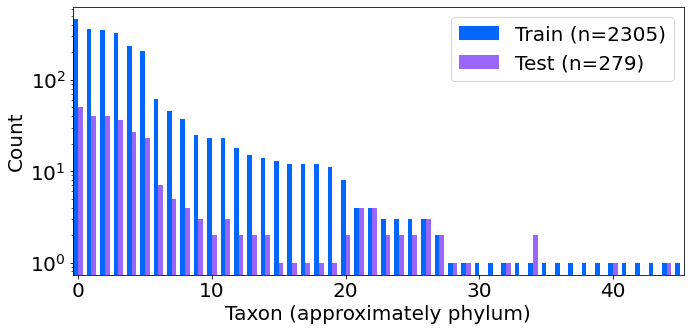

In [764]:
fig, labels = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, taxid_to_tla)
plt.savefig("/Users/natasha/Desktop/fig_dist.png", bbox_inches='tight')

In [ ]:
# mod = 'M00001'
# a = list(mod_sets[mod].values())
# a.sort(reverse=True)
# x_labels = [i for i in range(len(mod_sets[mod].values()))]
# plt.bar(x_labels, a)
# plt.yscale('log')
# plt.title("Variants of module "+mod)
# plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
# plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
# print(max(mod_sets[mod].values()), len(a))

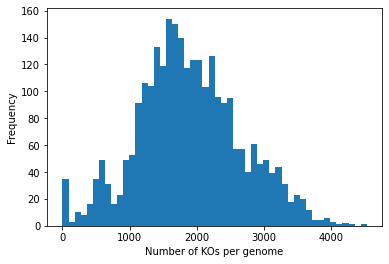

In [7]:
# Plot the number of KOs encoded by each genome
plt.hist([len(org_to_kos[i]) for i in org_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig("/Users/natasha/Desktop/fig.png")

In [ ]:
# # Plot the number of modules encoded by each genome
# n_genomes = len(org_to_mod_to_kos)
# temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
# n_mods = len(list(set([item for sublist in temp for item in sublist])))
# plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
# plt.xlabel("Number of modules per genome")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [ ]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [ ]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [ ]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [ ]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [ ]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [ ]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [ ]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [ ]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [ ]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# New corruption process

In [8]:
# Remove any genomes with fewer than 500 KOs 
# Esp. important to remove genomes with 0 KOs (n=35)

good_idx_train = train_data.sum(axis=1) > 500
good_idx_test = test_data.sum(axis=1) > 500
train_data = train_data[good_idx_train,:]
test_data = test_data[good_idx_test,:]

# to numpy for indexing, then back to list for using
train_genomes = list(np.array(train_genomes)[good_idx_train])
test_genomes = list(np.array(test_genomes)[good_idx_test])

In [ ]:
# Remove columns of all zeros in training set from train + test
# good_idx_train = train_data.sum(axis=0) > 0
# train_data = train_data[:,good_idx_train]
# test_data = test_data[:,good_idx_train]

In [9]:
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 83)

In [10]:
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1603)

In [ ]:
# original version of corrupt used with DAE (pre-DVAE)

# new_corrupt = False

# if new_corrupt:
#     corrupted_train, train_genome_idx = corrupt.corrupt_orig(train_data, settings.num_corruptions, 0.5)
#     corrupted_test, test_genome_idx = corrupt.corrupt_orig(test_data, settings.num_corruptions, 0.5)
#     torch.save(corrupted_train, "/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
#     torch.save(corrupted_test, "/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
#     torch.save(train_genome_idx, "/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
#     torch.save(test_genome_idx, "/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")
# else:
#     corrupted_train = torch.load("/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
#     corrupted_test = torch.load("/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
#     train_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
#     test_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")

In [12]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
date_to_save = "2020-10-16_10mods"
date_to_load = "2020-10-16_10mods"
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

if new_corrupt:
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt(train_data, train_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt(test_data, test_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos)
    torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, "/Users/natasha/Desktop/c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, "/Users/natasha/Desktop/c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, "/Users/natasha/Desktop/train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, "/Users/natasha/Desktop/test_input_mods_"+date_to_save+".pt")
else:
    corrupted_train = torch.load("/Users/natasha/Desktop/corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load("/Users/natasha/Desktop/c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load("/Users/natasha/Desktop/corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load("/Users/natasha/Desktop/c_test_genomes_"+date_to_load+".pt")
    

In [14]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > 499
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [15]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19748]), torch.Size([27900, 19748]))

# Define and train network

In [ ]:
# memory = 2000 * 1024 * 1024
# object_store_memory = 200 * 1024 * 1024
# driver_object_store_memory=100 * 1024 * 1024
# ray.shutdown()
# ray.init(local_mode=True, memory=memory, 
#         object_store_memory=object_store_memory,
#         driver_object_store_memory=driver_object_store_memory,
#         num_cpus=10)

In [ ]:
# config = {"num_epochs": 10,
#          "kfolds": 10,
#          "replacement_threshold": settings.replacement_threshold,
#          "nn_layers": tune.choice([1, 2, 3, 4]),
#          "batch_size": tune.choice([32, 64, 128, 256]),
#           "lr": tune.loguniform(1e-4, 1e-1), 
#           "weight_decay": tune.loguniform(1e-5, 1e-2) 
#          }

In [ ]:
# analysis = tune.run(
#     trainable.train_AE, 
#     name="sept_22_vae",
#     config=config,
#     verbose=2, 
#     resources_per_trial={
#             "cpu": 10,
#             "gpu": 0
#     },
#     num_samples=20,  
#     queue_trials=True,
#     #local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
#     local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
#     )

In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.get_best_config(metric="test_f1")

# Evaluate model performance

In [ ]:
# trainable.train_single_dae(3, 0.01, 0.001, 128, 10, 10, 0.5)

In [ ]:
kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(3, 0.1, 0.001, 128, 10, 3, 0.5, corrupted_train, corrupted_test)


In [ ]:
torch.save(model.state_dict(), "/Users/natasha/Desktop/model.pt")
torch.save(train_losses, "/Users/natasha/Desktop/train_losses.pt")
torch.save(test_losses, "/Users/natasha/Desktop/test_losses.pt")
torch.save(bce0, "/Users/natasha/Desktop/bce0.pt")
torch.save(kld0, "/Users/natasha/Desktop/kld0.pt")
torch.save(train_f1s, "/Users/natasha/Desktop/train_f1s.pt")
torch.save(test_f1s, "/Users/natasha/Desktop/test_f1s.pt")

In [16]:
load_model = False
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load("/Users/natasha/Desktop/model.pt"))
    model.eval()

In [241]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81

n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [240]:
model.eval()
with torch.no_grad():
    pred = model.forward(corrupted)[0].detach()

binary_pred = evaluate.eval_binarize(pred, 0.5)

In [31]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print(f1)

0.8092024604736346


In [61]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


83.17269168585104 2.1012582917520617 3.294075240503462 11.431974781893436


In [ ]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

In [ ]:
fig = data_viz.learning_curve(train_losses, test_losses, "optimization", False)
fig.savefig("/Users/natasha/Desktop/optimization_lc.png", bbox_inches='tight', dpi=200)

In [ ]:
fig = data_viz.learning_curve(train_f1s, test_f1s, "performance", False)
fig.savefig("/Users/natasha/Desktop/performance_lc.png", bbox_inches='tight', dpi=200)

In [ ]:
idx = 1
fig = data_viz.genome_heatmap2(corrupted_test, idx, model)
fig.savefig("/Users/natasha/Desktop/fig4.png", bbox_inches='tight', dpi=200)

In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())

In [ ]:
fig.savefig("/Users/natasha/Desktop/roc_fig.png", dpi=200, bbox_inches='tight')

# Baseline models

In [37]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [229]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, "/Users/natasha/Desktop/baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load("/Users/natasha/Desktop/baseline1.pt")

Generating new baseline 1


In [230]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

0.18970243309483728

In [231]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


68.49080166368647 16.78314831391664 11.424177612832079 3.3018724095648175


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


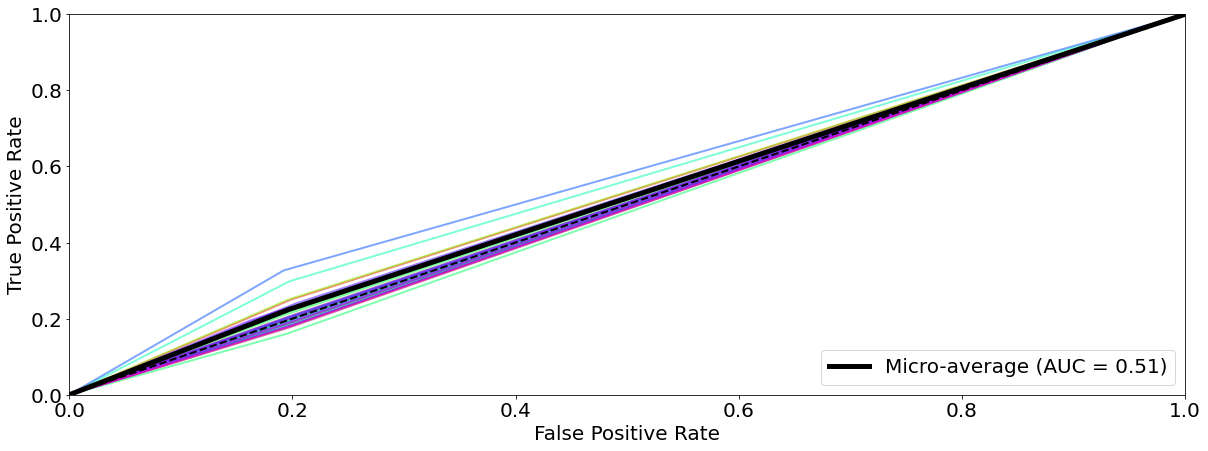

In [232]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [254]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, "/Users/natasha/Desktop/baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load("/Users/natasha/Desktop/baseline2.pt")
    

Generating new baseline 2


In [255]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

0.5248411859371813

In [256]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


74.31666488798285 10.957285089620255 5.588273173890665 9.137776848506233


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


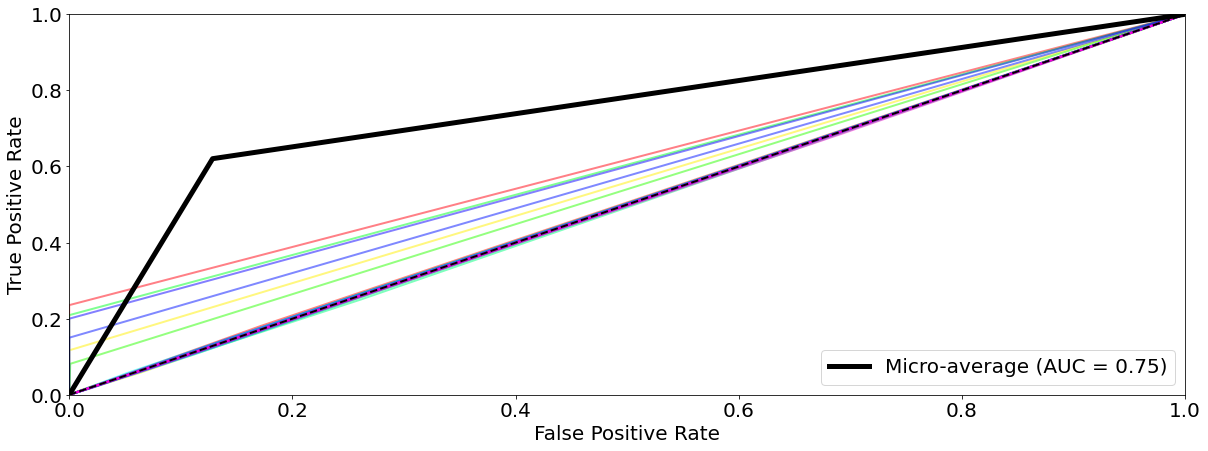

In [257]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [886]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, "/Users/natasha/Desktop/baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load("/Users/natasha/Desktop/baseline3.pt")

Generating new baseline 3


In [889]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

0.22753921405570246

In [890]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


42.11029182756496 43.16365815003815 7.294473084883873 7.4315769375130225


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


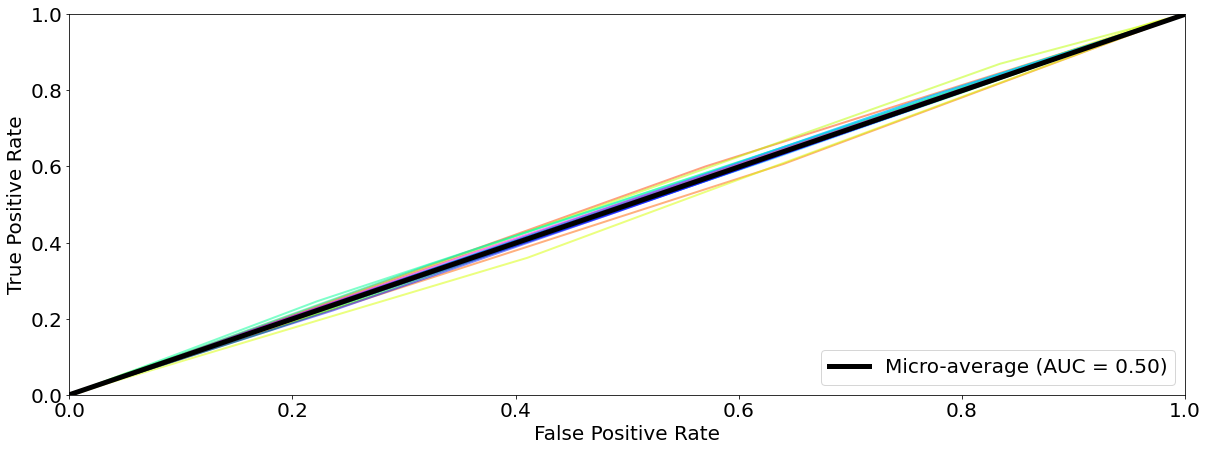

In [891]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [846]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline4, "/Users/natasha/Desktop/baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load("/Users/natasha/Desktop/baseline4.pt")

Generating new baseline 4


In [842]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

0.3785836804704729

In [843]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


83.90694071465337 1.3670092629497257 10.96848970868063 3.7575603137162656


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


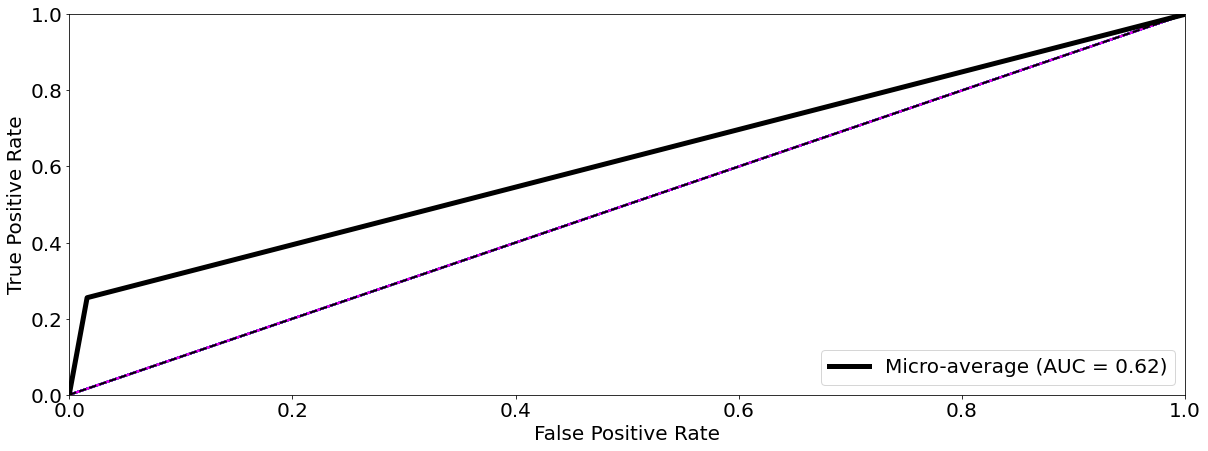

In [844]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [858]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline5, "/Users/natasha/Desktop/baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load("/Users/natasha/Desktop/baseline5.pt")

Generating new baseline 5
largest_tla bcai


In [860]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

0.5166804496751665

In [861]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


70.18000280233451 15.0939471752686 4.33893582436187 10.387114198035025


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


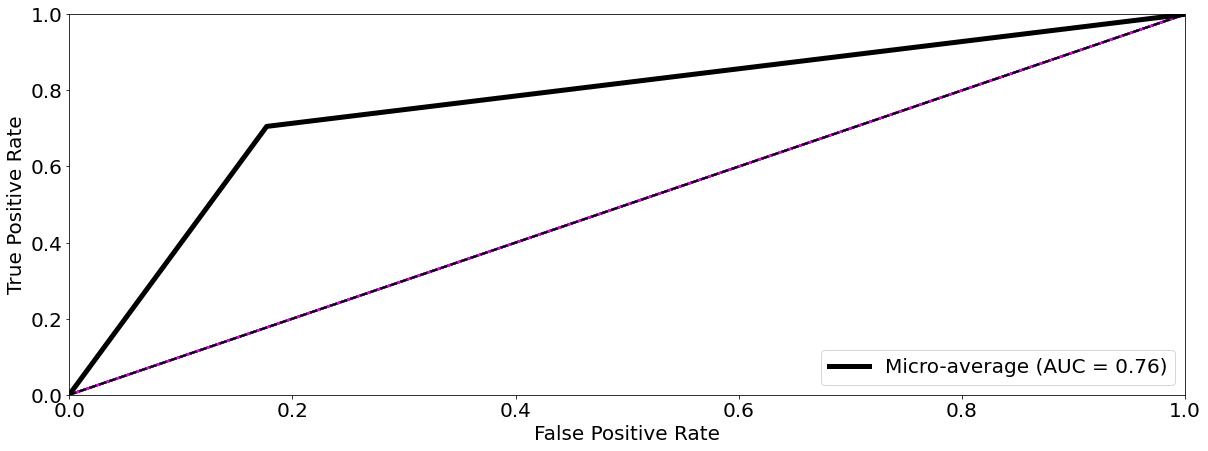

In [862]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())